# RNN with formatted text data

In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
df = pd.read_csv('../datasets/post_sub.csv')
df.head()

,post,subreddit
0,Lethargic/Depressed when off meds First I'll g...,adhd
1,Concerta not working on the first day?! Update...,adhd
2,Comorbid anxiety and ADHD-PI Medication Questi...,adhd
3,Fist Day on Concerta 18mg UPDATE! Update!: Tha...,adhd
4,I absolutely hate being so motivated but equal...,adhd


<Axes: title={'center': 'Number posts in each Subreddit'}, xlabel='subreddit'>

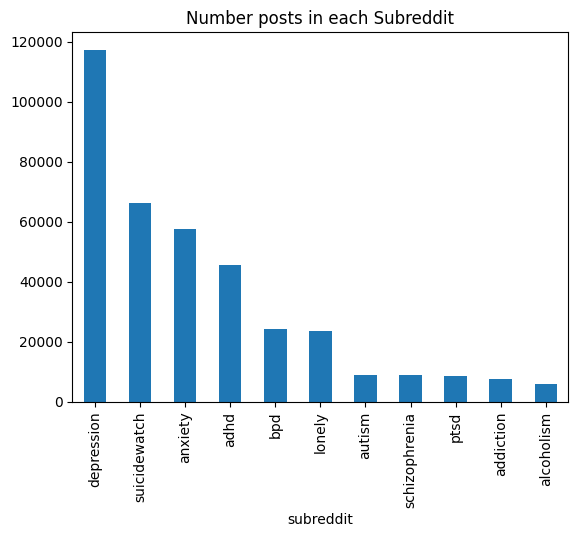

In [3]:
df['subreddit'].value_counts().sort_values(ascending=False).plot(kind='bar', 
                                                                title='Number posts in each Subreddit')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
import plotly.graph_objs as go
import plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

## Cleaning post data and tokenizing it

In [5]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!


True

Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


CompletedProcess(args=['unzip', '/kaggle/working/corpora/wordnet.zip', '-d', '/kaggle/working/corpora'], returncode=1)

In [5]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer


# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text

    # Lemmatize the text
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)

    return text
df['post'] = df['post'].apply(clean_text)
df['post'] = df['post'].str.replace('\d+', '')

In [6]:
count = df['post'].apply(lambda x: len(x.split()))

In [7]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 314003 unique tokens.


In [8]:
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (374499, 300)


In [9]:
Y = pd.get_dummies(df['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (374499, 11)


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)


In [12]:
# print tensorflow version
import tensorflow as tf
print(tf.__version__)

2.15.0


In [13]:
y_test = np.argmax(Y_test, axis=1)

## Training and evaluating the model with WandB

In [20]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'RNN_scratch_aayush.ipynb'


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTMCell, RNN, Dense, GRUCell, GRU
from tensorflow.keras.callbacks import EarlyStopping, Callback
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback

wandb.init(project='Best_models')

# Your data: X_train, X_val, X_test, y_train_encoded, y_val_encoded, y_test_encoded

# Manual specification of parameters for the first run
params = {
    'units': 300, 'batch': 32
}


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find RNN_scratch_aayush.ipynb.
wandb: Currently logged in as: aayushach16 (boys69). Use `wandb login --relogin` to force relogin


In [22]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 4 or epoch == 6:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_GRU_{}.hd5".format(epoch))

In [23]:

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(GRU(params['units'])) # Using LSTMCell here
model.add(Dense(11, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

epochs = 10
batch_size = params['batch']

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), WandbCallback()])

accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.7f}\n  Accuracy: {:0.7f}'.format(accr[0], accr[1]))

wandb.log({'test_loss': accr[0], 'test_acc': accr[1]})
wandb.log({'train_loss': history.history['loss'], 'val_loss': history.history['val_loss']})
wandb.log({'train_acc': history.history['accuracy'], 'val_acc': history.history['val_accuracy']})



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 200)          10000000  
                                                                 
 spatial_dropout1d (Spatial  (None, 300, 200)          0         
 Dropout1D)                                                      
                                                                 
 gru (GRU)                   (None, 300)               451800    
                                                                 
 dense (Dense)               (None, 11)                3311      
                                                                 
Total params: 10455111 (39.88 MB)
Trainable params: 10455111 (39.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
7022/7022 [==============================] - ETA: 0s - loss: 1.3338 - accuracy: 0.5237

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231128_133430-tpmgjz5x/files/model-best)... Done. 0.5s


7022/7022 [==============================] - 317s 45ms/step - loss: 1.3338 - accuracy: 0.5237 - val_loss: 1.0408 - val_accuracy: 0.6391
Epoch 2/10
7021/7022 [============================>.] - ETA: 0s - loss: 0.8782 - accuracy: 0.6969

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231128_133430-tpmgjz5x/files/model-best)... Done. 0.5s


7022/7022 [==============================] - 194s 28ms/step - loss: 0.8782 - accuracy: 0.6969 - val_loss: 0.8042 - val_accuracy: 0.7191
Epoch 3/10
7022/7022 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.7411

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231128_133430-tpmgjz5x/files/model-best)... Done. 0.5s


7022/7022 [==============================] - 190s 27ms/step - loss: 0.7349 - accuracy: 0.7411 - val_loss: 0.7729 - val_accuracy: 0.7265
Epoch 4/10
7022/7022 [==============================] - ETA: 0s - loss: 0.6764 - accuracy: 0.7588

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231128_133430-tpmgjz5x/files/model-best)... Done. 0.5s


7022/7022 [==============================] - 188s 27ms/step - loss: 0.6764 - accuracy: 0.7588 - val_loss: 0.7478 - val_accuracy: 0.7337
Epoch 5/10
7022/7022 [==============================] - 183s 26ms/step - loss: 0.6344 - accuracy: 0.7730 - val_loss: 0.7529 - val_accuracy: 0.7314
Epoch 6/10
7022/7022 [==============================] - 183s 26ms/step - loss: 0.5996 - accuracy: 0.7848 - val_loss: 0.7575 - val_accuracy: 0.7334
Epoch 7/10
2341/2341 [==============================] - 23s 10ms/step - loss: 0.7624 - accuracy: 0.7332
Test set
  Loss: 0.7623938
  Accuracy: 0.7331775


## Results of the model

In [24]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)
cm = confusion_matrix(y_test, y_pred_argmax)

2341/2341 [==============================] - 19s 8ms/step


In [25]:
# Generating a classification report
print("Classification Report:\n", classification_report(y_test, y_pred_argmax))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78      1577
           1       0.88      0.88      0.88      9182
           2       0.80      0.80      0.80      1254
           3       0.78      0.84      0.81     11419
           4       0.89      0.76      0.82      1754
           5       0.78      0.69      0.73      4899
           6       0.68      0.70      0.69     23472
           7       0.65      0.60      0.62      4724
           8       0.78      0.70      0.73      1766
           9       0.81      0.69      0.74      1788
          10       0.65      0.66      0.66     13065

    accuracy                           0.73     74900
   macro avg       0.78      0.73      0.75     74900
weighted avg       0.73      0.73      0.73     74900



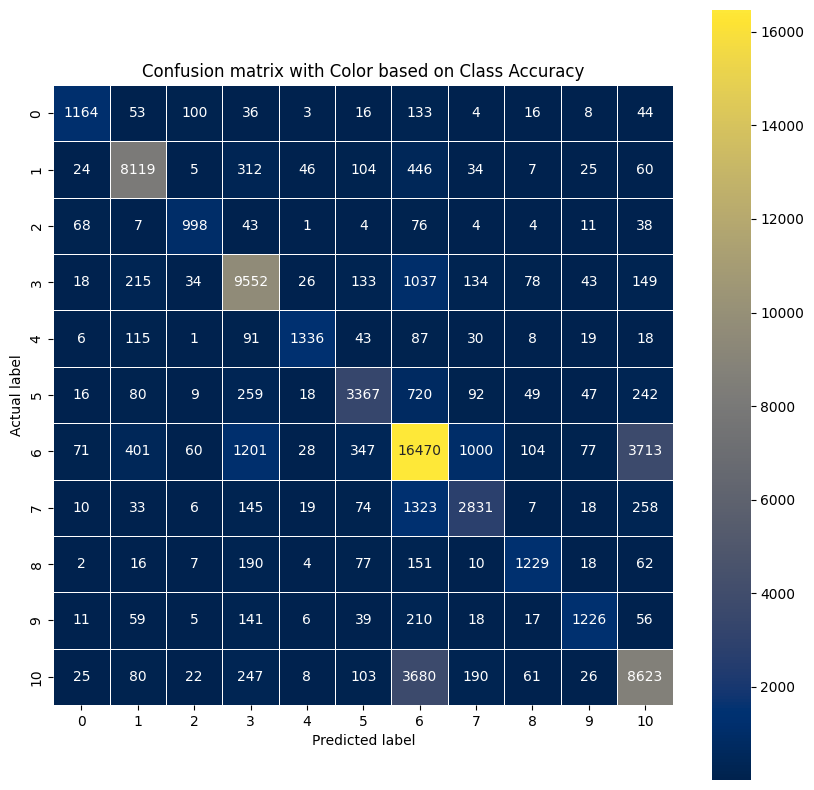

In [26]:
# Plotting the confusion matrix with the defined colormap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='cividis')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix with Color based on Class Accuracy')
plt.show();

In [ ]:
del model